# GIK Character Prediction Model

Train a model to predict keyboard characters from IMU sensor data.


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import sys
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

# Add project root to path
PROJECT_ROOT = os.path.dirname(os.path.abspath('__file__'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

from pretraining import preprocess_multiple_sources, load_preprocessed_dataset, export_dataset_to_csv, get_class_weights
from src.pre_processing.alignment import INDEX_TO_CHAR, CHAR_TO_INDEX, NUM_CLASSES
from src.pre_processing.reduce_dim import reduce_dim
from ml.models.gik_model import create_model_auto_input_dim, GIKTrainer, decode_predictions
from ml.models.loss_functions.custom_losses import FocalLoss, CoordinateLoss, CoordinateLossClassification

torch.manual_seed(42)
np.random.seed(42)

DEVICE = 'cuda' if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else 'cpu'
print(f"PyTorch {torch.__version__} | Device: {DEVICE}")

PyTorch 2.10.0 | Device: mps


## Configuration

In [3]:
# Refined coordinates for letters and digits, trying to map out the real QWERTY keyboard layout
KEY_COORDS = {

    '1': (0.0, 0.0), '2': (1.0, 0.0), '3': (2.0, 0.0), '4': (3.0, 0.0), '5': (4.0, 0.0), '6': (5.0, 0.0), '7': (6.0, 0.0), '8': (7.0, 0.0), '9': (8.0, 0.0), '0': (9.0, 0.0),

    'q': (0.5, 1.0), 'w': (1.5, 1.0), 'e': (2.5, 1.0), 'r': (3.5, 1.0), 't': (4.5, 1.0), 'y': (5.5, 1.0), 'u': (6.5, 1.0), 'i': (7.5, 1.0), 'o': (8.5, 1.0), 'p': (9.5, 1.0),

    'a': (0.8, 2.0), 's': (1.8, 2.0), 'd': (2.8, 2.0), 'f': (3.8, 2.0), 'g': (4.8, 2.0), 'h': (5.8, 2.0), 'j': (6.8, 2.0), 'k': (7.8, 2.0), 'l': (8.8, 2.0),

    'z': (1.3, 3.0), 'x': (2.3, 3.0), 'c': (3.3, 3.0), 'v': (4.3, 3.0), 'b': (5.3, 3.0), 'n': (6.3, 3.0), 'm': (7.3, 3.0),
}

# Approximate coordinates for specials so they sit in plausible places
SPECIAL_COORDS = {
    '\n': (12.0, 2.0),  # enter to the right of L
    '\b': (12.0, 0.0),  # backspace to the right of P
    '\t': (-0.5, 1.0),  # tab to the left of Q
}

SPACE_ANCHORS = [ # Make space bar long
    (3.3, 4.0),  # under C
    (4.3, 4.0),  # under v
    (5.3, 4.0),  # under B
    (6.3, 4.0),  # under N
    (7.3, 4.0),  # under M

]

ALL_CHARS = [INDEX_TO_CHAR[i] for i in range(40)]

FULL_COORDS = {}
for ch in ALL_CHARS:
    if ch in KEY_COORDS:
        FULL_COORDS[ch] = KEY_COORDS[ch]
    elif ch in SPECIAL_COORDS:
        FULL_COORDS[ch] = SPECIAL_COORDS[ch]
    elif ch == ' ':
        # handled via SPACE_ANCHORS below
        FULL_COORDS[ch] = (5.3, 4.0)
    else:
        # generic fallback (e.g., if something unexpected appears)
        FULL_COORDS[ch] = (5.3, 4.0) # default to spacebar center

In [16]:
# Data paths - Using data_hazel_2 with multiple sources
DATA_DIR = "data_jun_3"

# Multiple data sources (paired keyboard + IMU files)
KEYBOARD_FILES = ["Keyboard_13.csv" ]
LEFT_FILES = ["Left_13.csv"]
RIGHT_FILES = None  # Set to list of files if available

PROCESSED_DATA_PATH = os.path.join(DATA_DIR, "processed_dataset.pt")

# Training config - OPTIMIZED (best: LSTM + Focal Loss ~37% test acc)
CONFIG = {
    # PRE-PROCESSING ARGS
    'max_seq_length': 10,
    
    # GIK Model WRAPPER ARGS (Input Projection Layer + Classification Head) 
    'hidden_dim_classification_head': 128,
    'num_layers': 2,
    'dropout': 0.5,  # Increased for regularization
    'output_logits': 2, # Change for Coordinate Loss 
    
    # Dataset Args
    'is_one_hot': False,
    'key_mapping_dict': FULL_COORDS, # Enable for Coordinate Loss 
    # 'key_mapping_dict': CHAR_TO_INDEX,
    'reduce_dim' : True,
    'return_class_id' : True,  # Enable for Coordinate Loss 
    "enable_class_weights": True, 
    
    # TRAINER ARGS 
    'batch_size': 64,
    'learning_rate': 5e-4,
    'weight_decay': 1e-3,  # L2 regularization
    'epochs': 300,
    'early_stopping': 40,
    'regression': True, # Enable for Coordinate Loss 
    
    # INNER MODEL ARGS
    # Model: 'lstm' (best) | 'transformer' | 'attention_lstm' | 'gru' | 'rnn' | 'cnn'
    'model_type': 'attention_lstm',
    'hidden_dim_inner_model': 128,
    'inner_model_prams': {
                          'bidirectional' : True, 
                          'dropout' : 0.5, 
                          'num_layers' : 2, 
                          'num_heads': 16},
    
    # LOSS Function ARGS
    'loss': CoordinateLossClassification,  # Handles class imbalance
    # 'loss': FocalLoss,
    'loss_params': {"h_v_ratio" : 0.5, "bias" : 0.3},
    # 'loss_params': {"gamma" : 2,},
    
}

print(f"Data dir: {DATA_DIR}")
print(f"Keyboard files: {KEYBOARD_FILES}")
print(f"Left IMU files: {LEFT_FILES}")
print(f"Right IMU files: {RIGHT_FILES}")
print(f"Model: {CONFIG['model_type']}")
print(f"Seq length: {CONFIG['max_seq_length']}")

Data dir: data_jun_3
Keyboard files: ['Keyboard_13.csv']
Left IMU files: ['Left_13.csv']
Right IMU files: None
Model: attention_lstm
Seq length: 10


## Preprocess Data

In [4]:
# Preprocess and combine multiple data sources
metadata = preprocess_multiple_sources(
    data_dir=DATA_DIR,
    keyboard_files=KEYBOARD_FILES,
    left_files=LEFT_FILES,
    right_files=RIGHT_FILES,
    output_path=PROCESSED_DATA_PATH,
    max_seq_length=CONFIG['max_seq_length'],
    normalize=True,
    apply_filtering=True
)

Loading data from data_jun_3...
  Keyboard files: ['Keyboard_13.csv']
  Left IMU files: ['Left_13.csv']

Processing source 1/1: Keyboard_13.csv
Skipped characters : {'caps lock': 12, 'shift': 2, 'esc': 1}
  Added 2289 samples (total: 2289)

Total skipped characters: {'caps lock': 12, 'shift': 2, 'esc': 1}

Processing 2289 total samples...

Saved preprocessed dataset to data_jun_3/processed_dataset.pt
Saved metadata to data_jun_3/processed_dataset_metadata.json
  - Total samples: 2289
  - Feat dim: 59
  - Sources combined: 1


In [5]:
print(f"\nTotal Samples: {metadata['num_samples']} | Feat dim: {metadata['feat_dim']} | Sources: {metadata['num_sources']}")


Total Samples: 2289 | Feat dim: 59 | Sources: 1


In [6]:
# Export to CSV for inspection (optional)
export_dataset_to_csv(PROCESSED_DATA_PATH, DATA_DIR, include_features=True)

Saved summary to data_jun_3/dataset_summary.csv
Saved features to data_jun_3/dataset_features.csv

Dataset Info:
  Total samples: 2289
  Exported samples: 2289
  Feat dim: 59
  Max seq length: 10

Class Distribution:
  f: 527
  d: 362
  g: 338
  e: 201
  r: 177
  s: 173
  SPACE: 105
  a: 79
  v: 74
  w: 68
  b: 47
  t: 37
  c: 32
  z: 28
  q: 20


'data_jun_3/dataset_summary.csv'

## Dimensionality Reduction

In [17]:
if CONFIG["reduce_dim"]:
    DIM_RED_OUTPUT = os.path.join(DATA_DIR, "dim_red_output.pt")

    # Ideally pass the metadata from preprocessing instead of manually setting it here but this avoids having to rerun the preprocessing step
    HAS_LEFT = False
    HAS_RIGHT = True

    # dims = reduce_dim(
    #     data_dir=PROCESSED_DATA_PATH,
    #     method="active-imu",
    #     has_left=HAS_LEFT,
    #     has_right=HAS_RIGHT, 
    #     normalise=True,
    #     output_path=DIM_RED_OUTPUT)
    
    dims = reduce_dim(
        data_dir=PROCESSED_DATA_PATH,
        method="pca",
        dims_ratio=0.4,
        has_left=HAS_LEFT,
        has_right=HAS_RIGHT, 
        normalise=True,
        output_path=DIM_RED_OUTPUT)

    print(f"Feature dimension reduced from {dims['dim_bef']} to {dims['dim_aft']}")

Feature dimension reduced from 59 to 23


## Balance DataSet

In [18]:
if CONFIG["enable_class_weights"]:
    class_weights = get_class_weights(DIM_RED_OUTPUT if CONFIG["reduce_dim"] else PROCESSED_DATA_PATH)
    # class_weights.to(DEVICE)
    if CONFIG["loss_params"] == FocalLoss:
        CONFIG["loss_params"]["alpha"] = class_weights
    else:
        CONFIG["loss_params"]["class_weights"] = class_weights

## Load Dataset & Create Model

In [19]:
dataset = load_preprocessed_dataset(DIM_RED_OUTPUT if CONFIG["reduce_dim"] else PROCESSED_DATA_PATH, 
                                    is_one_hot_labels=CONFIG["is_one_hot"],
                                    char_to_index=CONFIG["key_mapping_dict"],
                                    return_class_id=CONFIG["return_class_id"])
print(f"Dataset: {len(dataset)} samples | Input dim: {dataset.input_dim}")

# Create model
model = create_model_auto_input_dim(
    dataset,
    model_type=CONFIG['model_type'],
    hidden_dim_inner_model=CONFIG['hidden_dim_inner_model'],
    hidden_dim_classification_head=CONFIG['hidden_dim_classification_head'],
    no_layers_classification_head=CONFIG['num_layers'],
    dropout_inner_layers=CONFIG['dropout'],
    inner_model_kwargs=CONFIG['inner_model_prams'],
    output_logits = CONFIG['output_logits'],
)

# Print model architecture
print("\n" + "=" * 60)
print("Model architecture")
print("=" * 60)
print(model)
print("=" * 60)
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

Dataset: 2289 samples | Input dim: 25

Model architecture
GIKModelWrapper(
  (input_projection): Sequential(
    (0): Linear(in_features=25, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (inner_model): AttentionLSTM(
    (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
    (attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (projection): Linear(in_features=256, out_features=128, bias=True)
  )
  (project_from_inner): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    (2): ReLU()
  )
  (fc_stack): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    (2)

## Train Model

In [21]:
trainer = GIKTrainer(
    model=model,
    dataset=dataset,
    batch_size=CONFIG['batch_size'],
    learning_rate=CONFIG['learning_rate'],
    device=DEVICE,
    loss=CONFIG.get('loss'),
    loss_kwargs=CONFIG.get('loss_params'),
    regression=CONFIG.get('regression'),
)

history = trainer.train(
    epochs=CONFIG['epochs'],
    early_stopping_patience=CONFIG['early_stopping']
)

Training on mps
Train: 1831, Val: 228, Test: 230 (causal split, no shuffle)
------------------------------------------------------------
Epoch   1/300 
Train Loss: 0.5284 | Val Loss: 0.2517 
  -> Saved best model (val_loss: 0.2517)
Epoch   2/300 
Train Loss: 0.4763 | Val Loss: 0.2498 
  -> Saved best model (val_loss: 0.2498)
Epoch   3/300 
Train Loss: 0.4959 | Val Loss: 0.2493 
  -> Saved best model (val_loss: 0.2493)
Epoch   4/300 
Train Loss: 0.4666 | Val Loss: 0.2136 
  -> Saved best model (val_loss: 0.2136)
Epoch   5/300 
Train Loss: 0.4502 | Val Loss: 0.1915 
  -> Saved best model (val_loss: 0.1915)
Epoch   6/300 
Train Loss: 0.4030 | Val Loss: 0.1647 
  -> Saved best model (val_loss: 0.1647)
Epoch   7/300 
Train Loss: 0.3837 | Val Loss: 0.1576 
  -> Saved best model (val_loss: 0.1576)
Epoch   8/300 
Train Loss: 0.3482 | Val Loss: 0.1615 
Epoch   9/300 
Train Loss: 0.3532 | Val Loss: 0.1413 
  -> Saved best model (val_loss: 0.1413)
Epoch  10/300 
Train Loss: 0.3313 | Val Loss: 0.1

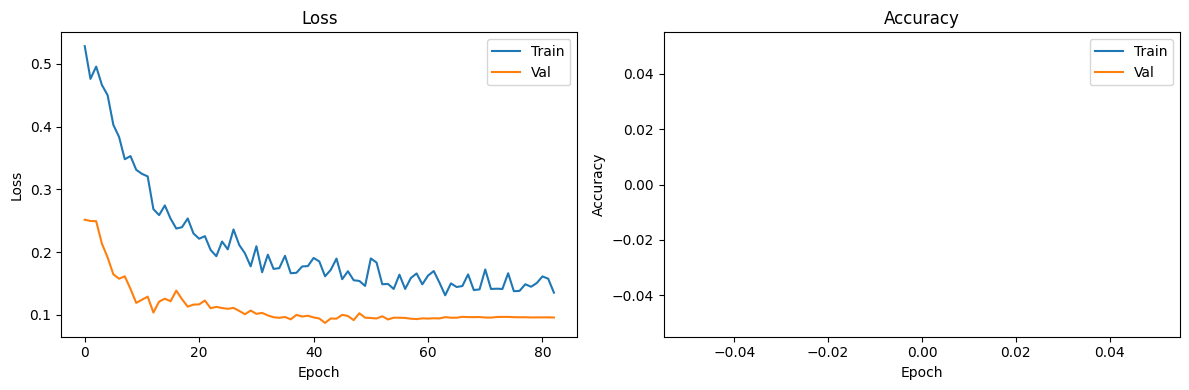

In [22]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(history['train_loss'], label='Train')
axes[0].plot(history['val_loss'], label='Val')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend()
axes[0].set_title('Loss')


axes[1].plot(history['train_acc'], label='Train')
axes[1].plot(history['val_acc'], label='Val')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].set_title('Accuracy')

plt.tight_layout()
plt.show()

## Evaluate Model

In [23]:
# Evaluate on validation set
val_loss, val_acc = trainer.validate()
print(f"Validation Loss: {val_loss:.4f}")  
# print("Validation Accuracy: {val_acc:.2%}")
print()

# Evaluate on test set
test_loss, test_acc = trainer.evaluate_test()
print(f"Test Loss: {test_loss:.4f}") 
# print(" Test Accuracy: {test_acc:.2%}")

Validation Loss: 0.0958

Test Loss: 0.1315


In [24]:
# Helper function to display predictions
def show_predictions(data_subset, subset_name, max_samples=50):
    """Show predictions for a dataset subset."""
    model.eval()
    correct = 0
    results = []
    
    with torch.no_grad():
        for idx in range(len(data_subset)):
            x, y_true = data_subset[idx]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            
            true_char = INDEX_TO_CHAR.get(y_true.argmax().item(), '?')
            pred_char = INDEX_TO_CHAR.get(y_pred.argmax().item(), '?')
            
            is_correct = true_char == pred_char
            if is_correct:
                correct += 1
            
            results.append((true_char, pred_char, is_correct))
    
    # Print header
    print(f"=== {subset_name} Predictions ({correct}/{len(results)} correct = {correct/len(results):.2%}) ===")
    print()
    
    # Show samples (up to max_samples)
    n_show = min(max_samples, len(results))
    for i, (true_char, pred_char, is_correct) in enumerate(results[:n_show]):
        # Display special chars nicely
        true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
        pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
        match = '✓' if is_correct else '✗'
        print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")
    
    if len(results) > n_show:
        print(f"... and {len(results) - n_show} more samples")
    print()

In [25]:
from torch.nn.functional import relu

def get_closest_coordinate(coord, coord_dict):
    """Return the character whose coordinate is closest to coord (L2 distance). coord: (2,) or (1,2) tensor or list."""
    if isinstance(coord, torch.Tensor):
        coord = coord.squeeze().cpu().numpy()
    coord = np.asarray(coord)
    best_char, best_dist = None, float('inf')
    for char, (cx, cy) in coord_dict.items():
        d = (coord[0] - cx) ** 2 + (coord[1] - cy) ** 2
        if d < best_dist:
            best_dist, best_char = d, char
    return best_char if best_char is not None else '?'



def show_predictions_coordinate(data_subset, subset_name, coord_dict=FULL_COORDS, max_samples=50):
    """Show predictions for coordinate (vector) mode: resolve predicted coords to char via nearest in coord_dict."""
    model.eval()
    correct = 0
    results = []
    dataset = data_subset.dataset
    indices = data_subset.indices

    with torch.no_grad():
        for i in range(len(data_subset)):
            x, y_true_vec,_ = data_subset[i]
            true_char = dataset._labels[indices[i]]
            x = x.unsqueeze(0).to(DEVICE)
            y_pred = model(x)
            y_pred = torch.sigmoid(y_pred)
            scale = y_pred.new_tensor([9.0, 4.0])
            y_pred = y_pred* scale
            pred_char = get_closest_coordinate(y_pred, coord_dict)

            is_correct = true_char == pred_char
            if is_correct:
                correct += 1
            results.append((true_char, pred_char, is_correct))

    print(f"=== {subset_name} Predictions ({correct}/{len(results)} correct = {correct/len(results):.2%}) ===")
    print()
    n_show = min(max_samples, len(results))
    for true_char, pred_char, is_correct in results[:n_show]:
        true_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(true_char, true_char)
        pred_disp = {'\n': 'ENTER', ' ': 'SPACE', '\t': 'TAB', '\b': 'BKSP'}.get(pred_char, pred_char)
        match = '✓' if is_correct else '✗'
        print(f"{match} True: {true_disp:8} | Pred: {pred_disp:8}")
    if len(results) > n_show:
        print(f"... and {len(results) - n_show} more samples")
    print()

In [26]:
# Show validation predictions
show_predictions_coordinate(trainer.val_dataset, 'Validation')

=== Validation Predictions (123/228 correct = 53.95%) ===

✓ True: g        | Pred: g       
✓ True: t        | Pred: t       
✓ True: r        | Pred: r       
✓ True: e        | Pred: e       
✓ True: d        | Pred: d       
✓ True: f        | Pred: f       
✗ True: g        | Pred: f       
✗ True: e        | Pred: w       
✓ True: r        | Pred: r       
✗ True: t        | Pred: g       
✓ True: g        | Pred: g       
✓ True: f        | Pred: f       
✗ True: d        | Pred: a       
✗ True: d        | Pred: f       
✗ True: e        | Pred: f       
✓ True: f        | Pred: f       
✗ True: f        | Pred: v       
✗ True: r        | Pred: t       
✓ True: g        | Pred: g       
✗ True: e        | Pred: r       
✓ True: e        | Pred: e       
✓ True: w        | Pred: w       
✓ True: e        | Pred: e       
✓ True: r        | Pred: r       
✓ True: f        | Pred: f       
✗ True: g        | Pred: b       
✗ True: f        | Pred: d       
✗ True: d        | Pred

In [27]:
# Show test predictions
show_predictions_coordinate(trainer.test_dataset, 'Test')

=== Test Predictions (102/230 correct = 44.35%) ===

✓ True: s        | Pred: s       
✓ True: s        | Pred: s       
✗ True: d        | Pred: f       
✓ True: f        | Pred: f       
✗ True: e        | Pred: r       
✓ True: e        | Pred: e       
✓ True: f        | Pred: f       
✓ True: d        | Pred: d       
✗ True: v        | Pred: f       
✗ True: SPACE    | Pred: v       
✗ True: c        | Pred: d       
✓ True: c        | Pred: c       
✗ True: s        | Pred: d       
✗ True: d        | Pred: a       
✗ True: f        | Pred: g       
✓ True: d        | Pred: d       
✗ True: s        | Pred: v       
✗ True: d        | Pred: f       
✗ True: f        | Pred: g       
✗ True: d        | Pred: f       
✗ True: d        | Pred: s       
✓ True: d        | Pred: d       
✗ True: d        | Pred: f       
✗ True: d        | Pred: s       
✓ True: s        | Pred: s       
✗ True: a        | Pred: r       
✓ True: a        | Pred: a       
✗ True: a        | Pred: w   

## Confusion Matrix

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import torch

def key_distance(ch1, ch2):
    """
    Distance between two keys.
    For space (' '), use the minimum distance to its multiple anchor points
    to mimic a long bar; other keys use their single coordinate.
    """
    def coords(ch):
        if ch == ' ':
            return SPACE_ANCHORS
        else:
            return [FULL_COORDS[ch]]

    pts1 = coords(ch1)
    pts2 = coords(ch2)

    d_min = float('inf')
    for (x1, y1) in pts1:
        for (x2, y2) in pts2:
            d = ((x1 - x2)**2 + (y1 - y2)**2)**0.5
            if d < d_min:
                d_min = d
    return d_min


def make_display_label(c):
    if c == ' ':
        return 'SP'
    elif c == '\n':
        return 'ENT'
    elif c == '\b':
        return 'BS'
    elif c == '\t':
        return 'TAB'
    else:
        return c


def compute_confusion_matrix_40x40(data_subset, model, device, coord_dict=None):
    """Return 40x40 confusion matrix. If coord_dict is None, labels are class indices/one-hot; else coordinate mode (resolve pred via get_closest_coordinate)."""
    model.eval()
    y_true_list = []
    y_pred_list = []
    dataset = data_subset.dataset
    indices = data_subset.indices

    with torch.no_grad():
        for i in range(len(data_subset)):
            x, y = data_subset[i]
            x = x.unsqueeze(0).to(device)
            y_pred = model(x)

            if coord_dict is not None:
                true_char = dataset._labels[indices[i]]
                pred_char = get_closest_coordinate(y_pred, coord_dict)
                y_true_list.append(CHAR_TO_INDEX.get(true_char, 0))
                y_pred_list.append(CHAR_TO_INDEX.get(pred_char, 0))
            else:
                y_true_list.append(y.argmax().item())
                y_pred_list.append(y_pred.argmax().item())

    labels_idx = list(range(40))
    cm_orig = confusion_matrix(y_true_list, y_pred_list, labels=labels_idx)
    return cm_orig

def plot_confusion_matrix_40x40(cm_orig, subset_name):
    """Plot the full 40x40 confusion matrix in original index order."""
    display_labels = [make_display_label(INDEX_TO_CHAR[i]) for i in range(40)]

    fig, ax = plt.subplots(figsize=(16, 14))
    sns.heatmap(
        cm_orig,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=display_labels,
        yticklabels=display_labels,
        ax=ax,
        annot_kws={'size': 7}
    )

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(
        f'{subset_name} Confusion Matrix (40 classes, raw counts)',
        fontsize=14,
        pad=40
    )

    plt.xticks(rotation=45, ha='right', fontsize=8)
    plt.yticks(rotation=0, fontsize=8)
    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------------
# 4. Local distance‑ordered view: anchor + 6 closest neighbours
# ---------------------------------------------------------------------

def plot_anchor_with_closest_neighbours(cm_orig, anchor_char, subset_name, k_neighbours=6):
    """
    For a given anchor_char, find its k_neighbours closest keys (by keyboard distance),
    and plot a confusion submatrix over [anchor + neighbours] in distance order
    (anchor first, then increasing distance). Also return that neighbour list.
    """
    if anchor_char not in FULL_COORDS:
        raise ValueError(f'No coords for anchor_char {anchor_char!r}')

    # char <-> index
    char_to_idx = {ch: idx for idx, ch in INDEX_TO_CHAR.items()}

    # sort all other chars by distance from anchor
    others = [ch for ch in ALL_CHARS if ch != anchor_char]
    others_sorted = sorted(others, key=lambda ch: key_distance(anchor_char, ch))

    # take closest k_neighbours
    closest_chars = others_sorted[:k_neighbours]

    # final ordered list: anchor first, then neighbours
    ordered_chars = [anchor_char] + closest_chars
    ordered_indices = [char_to_idx[ch] for ch in ordered_chars]
    ordered_display = [make_display_label(ch) for ch in ordered_chars]

    # submatrix of cm_orig
    cm_sub = cm_orig[ordered_indices][:, ordered_indices]

    # Plot
    fig, ax = plt.subplots(figsize=(8, 8))
    sns.heatmap(
        cm_sub,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=ordered_display,
        yticklabels=ordered_display,
        ax=ax,
        annot_kws={'size': 10}
    )

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.set_xlabel('Predicted', fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_title(
        f'{subset_name}: "{anchor_char}" + {k_neighbours} closest keys',
        fontsize=14,
        pad=40
    )

    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.show()

    return closest_chars, cm_sub


## Keyboard Heatmap

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def plot_virtual_keyboard_heatmap(cm_orig, anchor_char, subset_name):

    char_to_idx = {ch: idx for idx, ch in INDEX_TO_CHAR.items()}
    if anchor_char not in char_to_idx:
        raise ValueError(f'Unknown anchor_char {anchor_char!r}')

    i_anchor = char_to_idx[anchor_char]
    row = cm_orig[i_anchor].astype(float)  # length 40

    values = {INDEX_TO_CHAR[i]: row[i] for i in range(40)}

    all_vals = np.array(list(values.values()))
    vmax = all_vals.max() if np.any(all_vals > 0) else 1.0
    norm = mcolors.Normalize(vmin=0, vmax=vmax)
    cmap = plt.cm.Reds

    fig, ax = plt.subplots(figsize=(10, 5))

    key_width = 0.8
    key_height = 0.8

    for ch, (x, y) in KEY_COORDS.items():
        v = values.get(ch, 0.0)
        color = cmap(norm(v)) if v > 0 else (0.9, 0.9, 0.9, 1.0)
        rect = plt.Rectangle(
            (x - key_width/2, y - key_height/2),
            key_width,
            key_height,
            edgecolor='k',
            facecolor=color,
            zorder=2
        )
        ax.add_patch(rect)
        ax.text(x, y, ch.upper(), ha='center', va='center', fontsize=10, zorder=3)

    for ch, (x, y) in SPECIAL_COORDS.items():
        if ch == ' ':
            continue
        v = values.get(ch, 0.0)
        color = cmap(norm(v)) if v > 0 else (0.9, 0.9, 0.9, 1.0)
        label = {'\n': 'ENT', '\b': 'BS', '\t': 'TAB'}.get(ch, ch)
        rect = plt.Rectangle(
            (x - key_width/2, y - key_height/2),
            key_width,
            key_height,
            edgecolor='k',
            facecolor=color,
            zorder=2
        )
        ax.add_patch(rect)
        ax.text(x, y, label, ha='center', va='center', fontsize=9, zorder=3)

    xs = [p[0] for p in SPACE_ANCHORS]
    y_space = SPACE_ANCHORS[0][1]
    x_min, x_max = min(xs) - 0.4, max(xs) + 0.4
    space_width = x_max - x_min
    space_height = 0.8

    v_space = values.get(' ', 0.0)
    color_space = cmap(norm(v_space)) if v_space > 0 else (0.9, 0.9, 0.9, 1.0)

    space_rect = plt.Rectangle(
        (x_min, y_space - space_height/2),
        space_width,
        space_height,
        edgecolor='k',
        facecolor=color_space,
        zorder=1
    )
    ax.add_patch(space_rect)
    ax.text((x_min + x_max) / 2, y_space, 'SP', ha='center', va='center', fontsize=10, zorder=3)

    # Highlight anchor with thick border
    def outline_anchor(ch, lw=2.5, color='blue'):
        if ch == ' ':
            outline = plt.Rectangle(
                (x_min, y_space - space_height/2),
                space_width,
                space_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)
        elif ch in KEY_COORDS:
            x, y = KEY_COORDS[ch]
            outline = plt.Rectangle(
                (x - key_width/2, y - key_height/2),
                key_width,
                key_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)
        elif ch in SPECIAL_COORDS:
            x, y = SPECIAL_COORDS[ch]
            outline = plt.Rectangle(
                (x - key_width/2, y - key_height/2),
                key_width,
                key_height,
                fill=False,
                edgecolor=color,
                linewidth=lw,
                zorder=4
            )
            ax.add_patch(outline)

    outline_anchor(anchor_char)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('Predicted count')

    ax.set_aspect('equal', 'box')
    ax.set_xlim(-1.0, 13.0)
    ax.set_ylim(-1, 5.0)
    ax.invert_yaxis()
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(f'GIK Keyboard Heatmap Prediction when True Key = "{anchor_char}", {subset_name} set',
                 fontsize=14)
    plt.tight_layout()
    plt.show()


## Test Set Visualisation

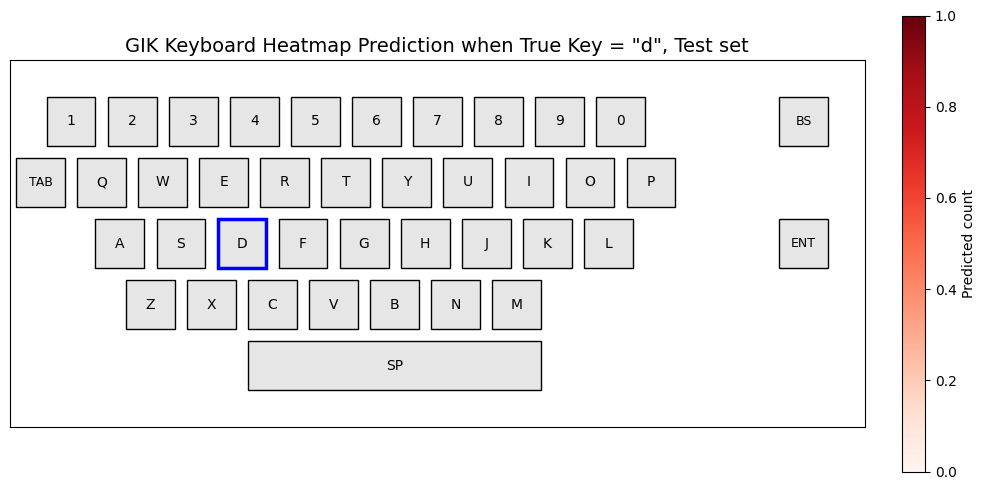

In [ ]:
# Use coord_dict in coordinate (regression) mode so predictions are resolved to chars via nearest key
coord_dict = FULL_COORDS if getattr(trainer, 'regression', False) else None
cm_orig = compute_confusion_matrix_40x40(trainer.test_dataset, model, DEVICE, coord_dict=coord_dict)

# plot_confusion_matrix_40x40(cm_orig, 'Test')

plot_virtual_keyboard_heatmap(cm_orig, 'd', 'Test')

# neighbours_a, cm_a = plot_anchor_with_closest_neighbours(cm_orig, 'i', 'Test', k_neighbours=5)

# neighbours_g, cm_g = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=5)

# neighbours_l, cm_l = plot_anchor_with_closest_neighbours(cm_orig, 'l', 'Test', k_neighbours=13)

In [ ]:
cm_orig_val = compute_confusion_matrix_40x40(trainer.val_dataset, model, DEVICE)

#plot_confusion_matrix_40x40(cm_orig, 'Test')

plot_virtual_keyboard_heatmap(cm_orig_val, 'o', 'test')

# neighbours_a_val, cm_a_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'd', 'Validation', k_neighbours=12)

# neighbours_g_val, cm_g_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'g', 'Validation', k_neighbours=20)

# neighbours_l_val, cm_l_val = plot_anchor_with_closest_neighbours(cm_orig_val, 'l', 'Validation', k_neighbours=13)

## Save Model

In [ ]:
# MODEL_PATH = os.path.join(DATA_DIR, "gik_model.pt")
# torch.save({
#     'model_state_dict': model.state_dict(),
#     'config': CONFIG,
#     'input_dim': dataset.input_dim,
#     'metadata': metadata
# }, MODEL_PATH)
# print(f"Model saved to {MODEL_PATH}")